In [1]:
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
from torch.optim.lr_scheduler import LinearLR, CosineAnnealingLR, SequentialLR
import matplotlib.pyplot as plt

In [2]:
epochs = 2000
batch_size = 4096
device = "mps"
lr = 3e-4
weight_decay = 1e-3

In [3]:
train_tensor = torch.from_numpy(np.load('train_array_largy.npy')).float()
train_labels = torch.from_numpy(np.load('train_score_array_large.npy')).float()
val_tensor = torch.from_numpy(np.load('val_array_large.npy')).float()
val_labels = torch.from_numpy(np.load('val_score_array_large.npy')).float()

train_loader = DataLoader(TensorDataset(train_tensor, train_labels), batch_size=batch_size, shuffle=True)
val_loader = DataLoader(TensorDataset(val_tensor, val_labels), batch_size=batch_size)

In [4]:
class Classifier(nn.Module):
    def __init__(self, dim: int):
        super().__init__()
        self.layer1 = nn.Linear(dim, dim*4)
        self.layer2 = nn.Linear(dim*4, dim)
        self.layer3 = nn.Linear(dim, 1)
        self.relu = nn.ReLU()
        self.norm1 = nn.LayerNorm(dim*4)
        self.norm2 = nn.LayerNorm(dim)
        self.dropout = nn.Dropout(p=0.5)

    def forward(self, x: torch.Tensor):
        x = self.dropout(self.relu(self.norm1(self.layer1(x))))
        x = self.dropout(self.relu(self.norm2(self.layer2(x))))
        return self.layer3(x).squeeze(-1)

In [5]:
model = Classifier(dim=3072).to(device)
criterion = nn.BCEWithLogitsLoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=lr, weight_decay=weight_decay)
total_steps = epochs*len(train_loader)
warmup_steps = int(total_steps * 0.01)

# Warmup: LR linearly increases from 0 → base LR over warmup_steps
warmup_scheduler = LinearLR(optimizer, start_factor=0.01, end_factor=1.0, total_iters=warmup_steps)
cosine_scheduler = CosineAnnealingLR(optimizer, T_max=(total_steps - warmup_steps), eta_min=3e-5)
scheduler = SequentialLR(optimizer, schedulers=[warmup_scheduler, cosine_scheduler], milestones=[warmup_steps])

In [6]:
metrics_list = []
for epoch in range(epochs):
    model.train()
    train_loss = 0
    val_loss = 0
    train_manhattan_dist = 0
    total_samples = 0
    for batch_x, batch_y in train_loader:
        batch_x, batch_y = batch_x.to(device), batch_y.to(device)
        
        optimizer.zero_grad()
        outputs = model(batch_x)
        loss = criterion(outputs, batch_y)
        loss.backward()
        optimizer.step()

        probs = torch.sigmoid(outputs)
        batch_dist = torch.abs(probs - batch_y).sum()
        train_manhattan_dist += batch_dist.item()
        total_samples += batch_y.size(0)
        
        train_loss += loss.item()
        scheduler.step()
    train_avg_manhattan = train_manhattan_dist / total_samples

    # Validation
    model.eval()
    val_manhattan_dist = 0.0
    total_samples = 0
    
    with torch.no_grad():
        for batch_x, batch_y in val_loader:
            batch_x, batch_y = batch_x.to(device), batch_y.to(device)
            
            # 1. Get raw logits from model
            logits = model(batch_x)
            val_loss += criterion(logits, batch_y).item()
            
            # 2. Convert logits to probabilities [0, 1]
            probs = torch.sigmoid(logits)
            
            # 3. Calculate Manhattan Distance: sum(|probs - ground_truth|)
            # We use .sum() to accumulate the distance for the whole batch
            batch_dist = torch.abs(probs - batch_y).sum()
            
            val_manhattan_dist += batch_dist.item()
            total_samples += batch_y.size(0)

    val_avg_manhattan = val_manhattan_dist / total_samples

    print(f"Epoch {epoch+1}/{epochs} | Train Loss: {train_loss/len(train_loader):.4f} | Val Loss: {val_loss/len(val_loader):.4f} | Avg Train Manhattan Dist: {train_avg_manhattan:.4f} | Avg Val Manhattan Dist: {val_avg_manhattan:.4f}")
    if epoch % 10 == 0:
        metrics_list.append(val_avg_manhattan)

Epoch 1/2000 | Train Loss: 0.6244 | Val Loss: 0.6016 | Avg Train Manhattan Dist: 0.2932 | Avg Val Manhattan Dist: 0.2744
Epoch 2/2000 | Train Loss: 0.6042 | Val Loss: 0.6016 | Avg Train Manhattan Dist: 0.2827 | Avg Val Manhattan Dist: 0.2906
Epoch 3/2000 | Train Loss: 0.6020 | Val Loss: 0.6036 | Avg Train Manhattan Dist: 0.2810 | Avg Val Manhattan Dist: 0.2948
Epoch 4/2000 | Train Loss: 0.6014 | Val Loss: 0.6001 | Avg Train Manhattan Dist: 0.2805 | Avg Val Manhattan Dist: 0.2879
Epoch 5/2000 | Train Loss: 0.6008 | Val Loss: 0.5982 | Avg Train Manhattan Dist: 0.2800 | Avg Val Manhattan Dist: 0.2777
Epoch 6/2000 | Train Loss: 0.6005 | Val Loss: 0.5983 | Avg Train Manhattan Dist: 0.2796 | Avg Val Manhattan Dist: 0.2807
Epoch 7/2000 | Train Loss: 0.6000 | Val Loss: 0.5982 | Avg Train Manhattan Dist: 0.2795 | Avg Val Manhattan Dist: 0.2765
Epoch 8/2000 | Train Loss: 0.5998 | Val Loss: 0.5979 | Avg Train Manhattan Dist: 0.2790 | Avg Val Manhattan Dist: 0.2781
Epoch 9/2000 | Train Loss: 0.599

KeyboardInterrupt: 

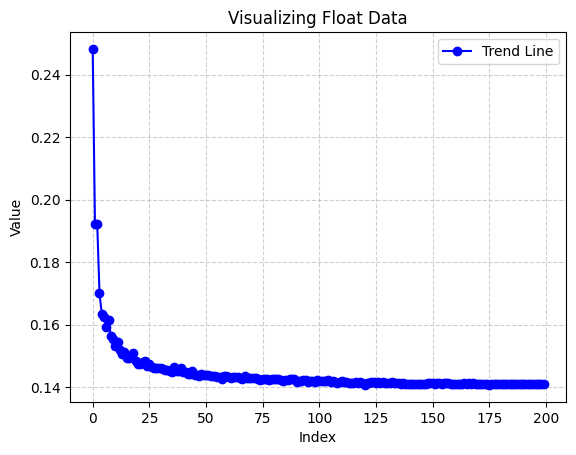

In [7]:
plt.plot(metrics_list, marker='o', linestyle='-', color='b', label='Trend Line')

# 2. Add flair and context
plt.title("Visualizing Float Data")
plt.xlabel("Index")
plt.ylabel("Value")
plt.grid(True, linestyle='--', alpha=0.6)
plt.legend()

# 3. Display the result
plt.show()

In [ ]:
torch.save(model.state_dict(), "large_classifier_weights.pt")